In [38]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Layer
from sklearn.metrics import average_precision_score

seed = 42
SIZE_X = 128
SIZE_Y = 128
n_channels = 3
n_classes = 10
Batch_size = 16
EPOCHS = 100
MODEL = 'unet'
activation = 'softmax'
BACKBONE = 'efficientnetb7'
encoder_weights = 'imagenet'
parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0(customized)'

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# img_data_gen_args = dict(rescale=1./255)
img_data_gen_args = dict()
mask_data_gen_args = dict()

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(f"{parent_directory}\\train_images", 
                                                           seed=seed, 
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y),
                                                           shuffle=False) 

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}\\train_masks", 
                                                         seed=seed, 
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y),
                                                           shuffle=False)


valid_img_generator = image_data_generator.flow_from_directory(f"{parent_directory}\\val_images", 
                                                           seed=seed, 
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y),
                                                           shuffle=False) 

valid_mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}\\val_masks", 
                                                         seed=seed, 
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y),
                                                           shuffle=False)


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

Found 1445 images belonging to 1 classes.
Found 1445 images belonging to 1 classes.
Found 450 images belonging to 1 classes.
Found 450 images belonging to 1 classes.


In [40]:
def preprocess_data(images, masks, unet_preporcessing):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)
    
    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

    return images, masks

In [41]:
from tensorflow.keras.utils import to_categorical

def load_data(image_generator, mask_generator, preprocessing_function=None):
    for (img, mask) in zip(image_generator, mask_generator):
        if preprocessing_function:
            img = preprocessing_function(img)
        mask = to_categorical(mask, num_classes=10)
        yield img, mask

In [32]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

def display_images_with_masks(image, mask, predicted=None):
    if predicted is not None:
      plt.figure(figsize=(12, 8))
    else:
      plt.figure(figsize=(14, 14))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(mask, (1, 1, 3))))
    if predicted is not None:
      plt.subplot(133)
      plt.title('Prediction')
      plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [34]:
x_train_batch, y_train_batch = next(train_generator)
x_train_batch.shape, y_train_batch.shape

((16, 128, 128, 3), (16, 128, 128, 1))

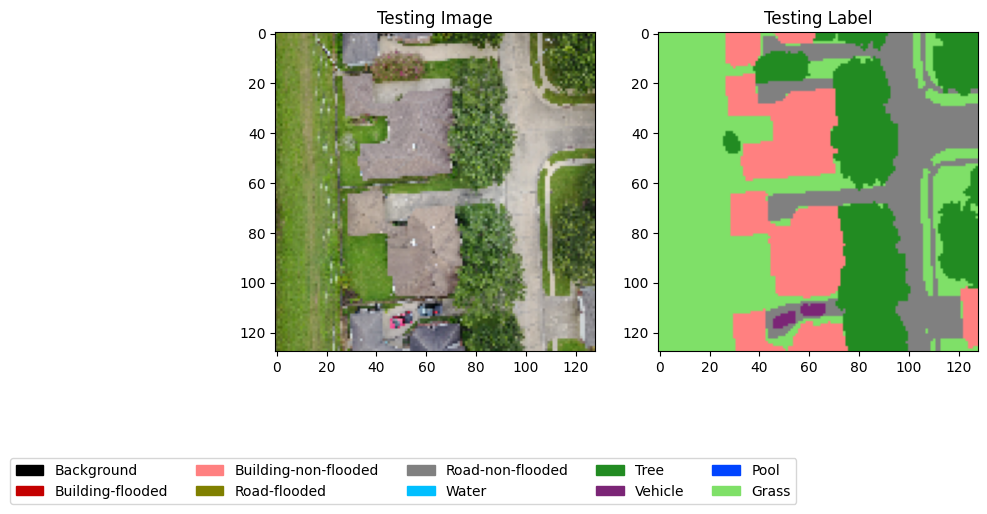

In [35]:
display_images_with_masks(x_train_batch[0], y_train_batch[0])

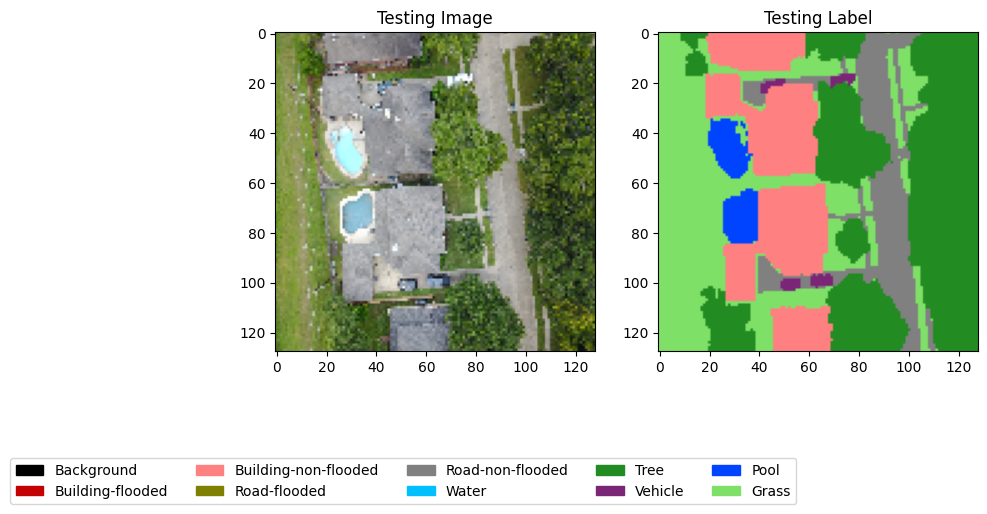

In [36]:
display_images_with_masks(x_train_batch[2], y_train_batch[2])

In [42]:
import segmentation_models as sm

preprocess_input = sm.get_preprocessing(BACKBONE)

train_generator = load_data(image_generator, mask_generator, preprocess_input)
val_generator = load_data(valid_img_generator, valid_mask_generator, preprocess_input)

In [10]:
next(train_generator)[0].shape, next(train_generator)[1].shape

((4, 128, 128, 3), (4, 128, 128, 10))

In [11]:
next(val_generator)[0].shape, next(val_generator)[1].shape

((4, 128, 128, 3), (4, 128, 128, 10))

In [43]:
import segmentation_models as sm

if MODEL == 'unet':
    model = sm.Unet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'fpn':
    model = sm.FPN(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'pspnet':
    model = sm.PSPNet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'linknet':
    model = sm.Linknet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
else:
    raise ValueError('Unknown model')

model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 64)   256         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 64)   0           ['stem_bn[0][0]']            

In [44]:
train_samples = len(os.listdir(f"{parent_directory}\\train_images\\train"))
val_samples = len(os.listdir(f"{parent_directory}\\val_images\\val"))
train_samples, val_samples

(1445, 450)

In [45]:
history = model.fit(train_generator, steps_per_epoch=(train_samples // Batch_size), epochs=EPOCHS, validation_data=val_generator, validation_steps=(val_samples // Batch_size),verbose=1)

Epoch 1/100
90/90 [==============================] - 332s 3s/step - loss: 1.2155 - iou_score: 0.0854 - val_loss: 1.2470 - val_iou_score: 0.1192
Epoch 2/100
90/90 [==============================] - 235s 3s/step - loss: 1.0584 - iou_score: 0.1355 - val_loss: 1.0161 - val_iou_score: 0.1881
Epoch 3/100
90/90 [==============================] - 233s 3s/step - loss: 1.0303 - iou_score: 0.1524 - val_loss: 0.9448 - val_iou_score: 0.2099
Epoch 4/100
90/90 [==============================] - 234s 3s/step - loss: 1.0055 - iou_score: 0.1700 - val_loss: 0.9386 - val_iou_score: 0.2165
Epoch 5/100
90/90 [==============================] - 233s 3s/step - loss: 0.9772 - iou_score: 0.1907 - val_loss: 0.9207 - val_iou_score: 0.2371
Epoch 6/100
90/90 [==============================] - 233s 3s/step - loss: 0.9570 - iou_score: 0.2075 - val_loss: 0.9369 - val_iou_score: 0.2358
Epoch 7/100
90/90 [==============================] - 233s 3s/step - loss: 0.9341 - iou_score: 0.2247 - val_loss: 0.8848 - val_iou_score:

In [46]:
model.input_shape

(None, 128, 128, 3)

In [47]:
model.output_shape

(None, 128, 128, 10)

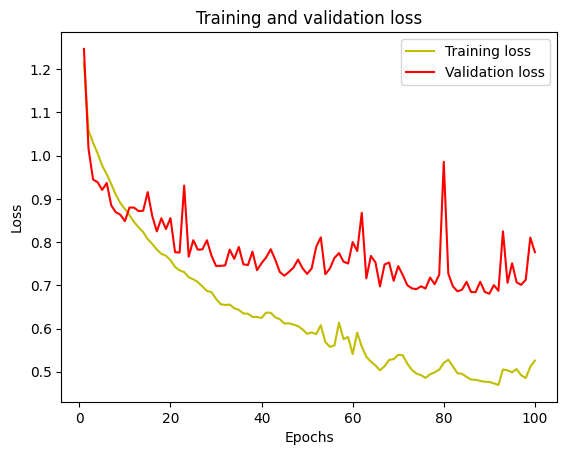

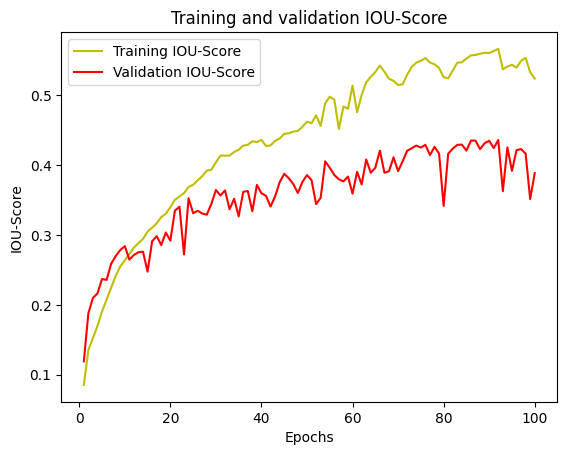

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [49]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y})-(suffle=False).hdf5')

In [ ]:
model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y})-(suffle=False).hdf5')

In [50]:
pickle_file_path = '../dataset/test_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

test_images, test_masks = preprocess_data(test_images, test_masks, preprocess_input)

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


In [51]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  17.269377410411835 %


In [52]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
predicted_masks = np.argmax(y_pred, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

print(predicted_masks.shape)
print(test_masks_.shape)

14/14 [==============================] - 7s 117ms/step
(448, 128, 128)
(448, 128, 128)


In [53]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

class_APs = []

for i in range(n_classes):
    class_predicted_masks = (predicted_masks == i).astype(int)
    class_test_masks = (test_masks_ == i).astype(int)
    
    class_predicted_masks_flat = class_predicted_masks.flatten().reshape(-1, 1)
    class_test_masks_flat = class_test_masks.flatten().reshape(-1, 1)
    
    class_APs.append(average_precision_score(class_test_masks_flat, class_predicted_masks_flat, average='micro'))

mAP_score = np.mean(class_APs)
print("Overall mAP score =", mAP_score)

Mean IoU = 0.19324401
IoU for each class:
Background: 0.11703763157129288
Building Flooded: 0.0012324090348556638
Building Non-Flooded: 0.03319179639220238
Road Flooded: 0.1600484997034073
Road Non-Flooded: 0.5929068922996521
Water: 0.09855357557535172
Tree: 0.2583029568195343
Vehicle: 0.010671349242329597
Pool: 0.0002555584069341421
Grass: 0.6602392792701721
Overall mAP score = 0.20109906989695148


In [54]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0: 
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

# Calculate mean IoU excluding background class
mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.19324401
IoU for each class:
Building Flooded: 0.0012324090348556638
Building Non-Flooded: 0.03319179639220238
Road Flooded: 0.1600484997034073
Road Non-Flooded: 0.5929068922996521
Water: 0.09855357557535172
Tree: 0.2583029568195343
Vehicle: 0.010671349242329597
Pool: 0.0002555584069341421
Grass: 0.6602392792701721
Mean IoU (excluding Background): 0.20171136


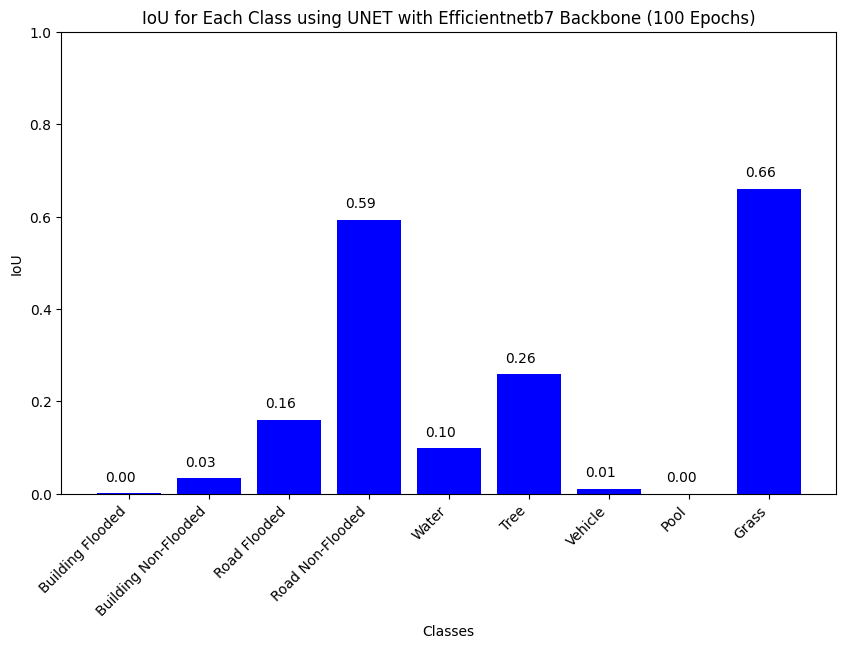

In [57]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1) 
plt.xticks(rotation=45, ha='right')  

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [58]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3)))) 
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [59]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


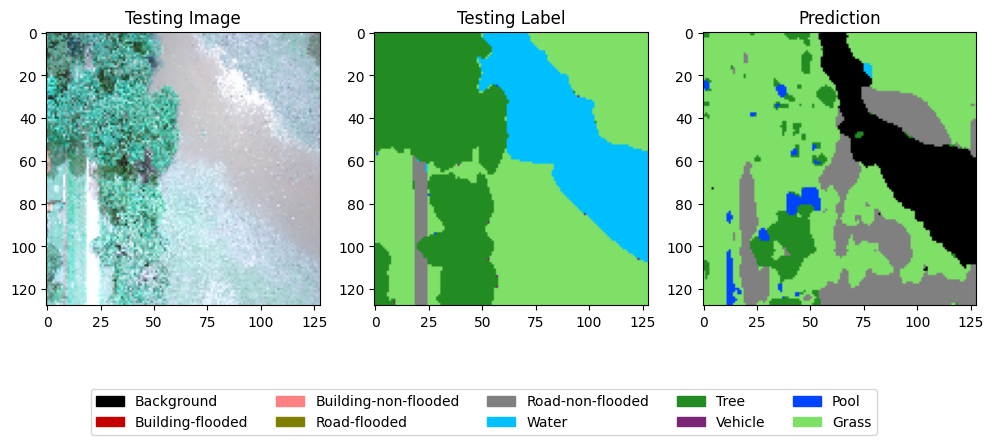

In [60]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


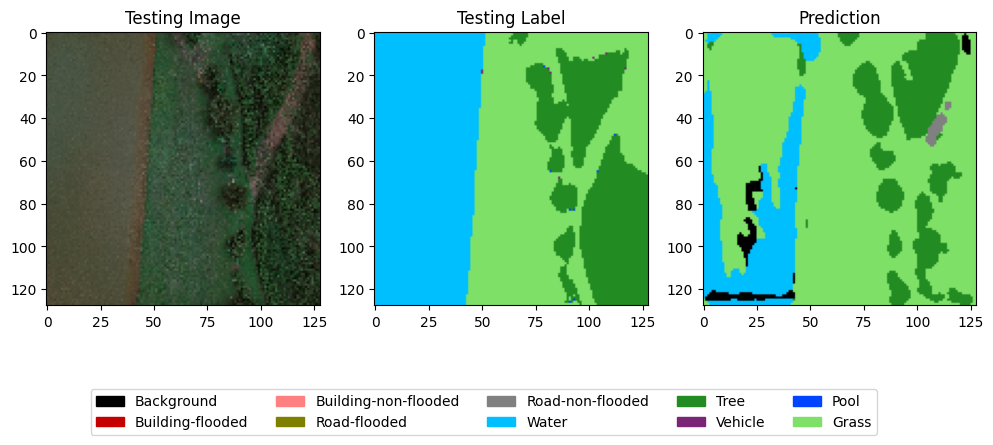

In [61]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


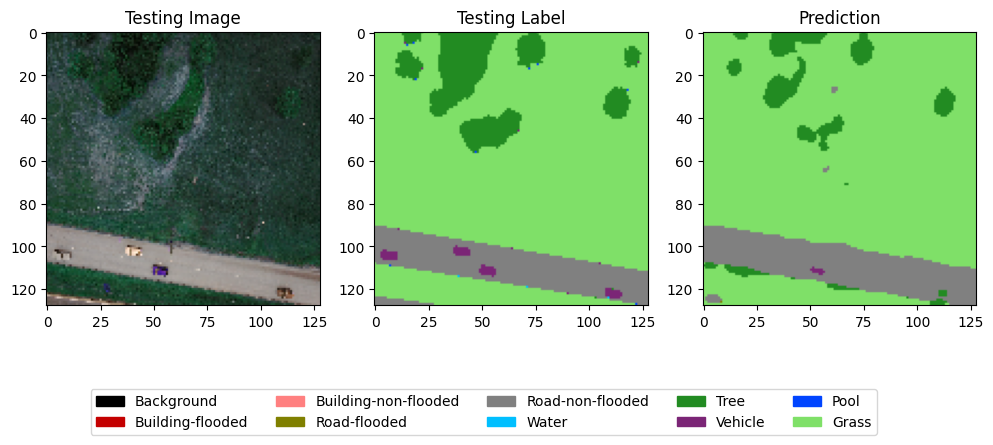

In [62]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


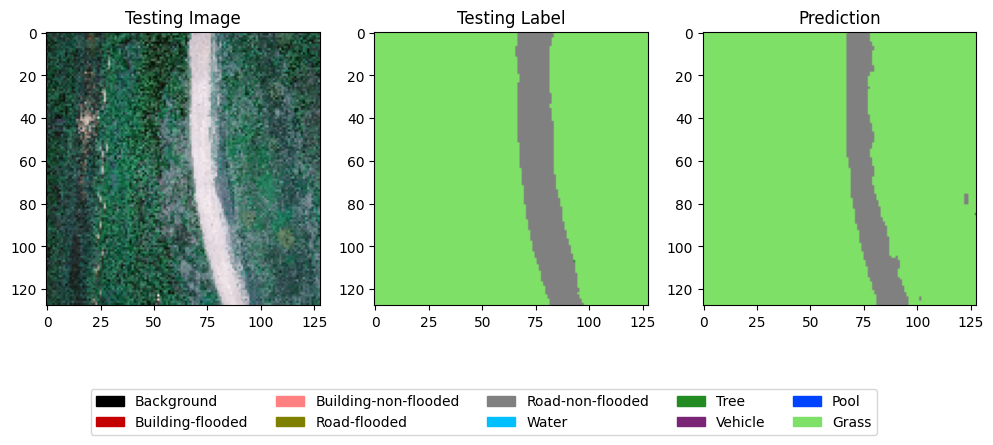

In [63]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


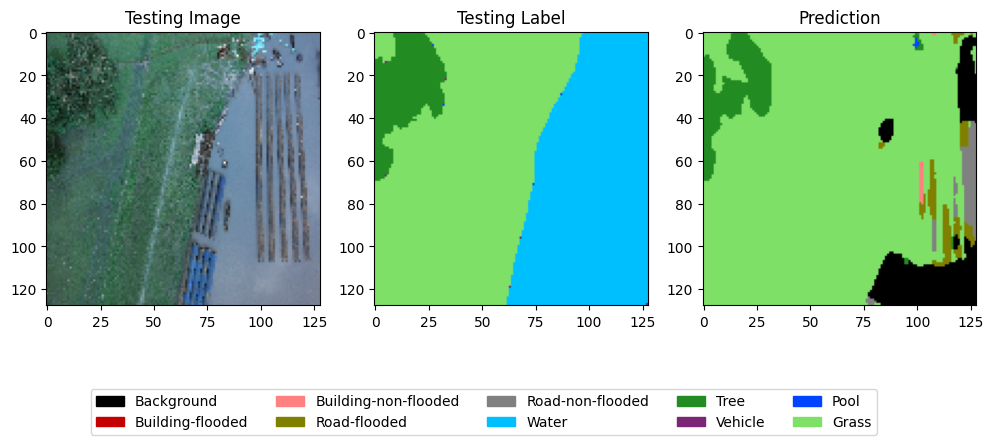

In [64]:
display_random_function()